:::{canonical-tutorial} tutorials/trajectories/paga-paul15
:::
original raw file was downloaded from https://github.com/scverse/scanpy-tutorials/blob/main/paga-paul15.ipynb

renamed in this workflow.

# Trajectory inference for hematopoiesis in mouse

:::{seealso}
More examples for trajectory inference on complex datasets can be found in the
[PAGA][] repository {cite:p}`Wolf2019`, for instance, multi-resolution analyses of whole animals,
such as for [planaria][] for data of {cite:t}`Plass2018`.

[PAGA]: https://github.com/theislab/paga
[planaria]: https://nbviewer.jupyter.org/github/theislab/paga/blob/master/planaria/planaria.ipynb


```{image} /_static/img/tutorials/paga_planaria.png
:width: 350px
:align: center
```
:::

Reconstructing myeloid and erythroid differentiation for data of {cite:t}`Paul2015`.

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

/config/workspace/.venv/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = "./write/paul15.h5ad"
# low dpi (dots per inch) yields small inline figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

In [3]:
adata = sc.datasets.paul15()

In [4]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

Let us work with a higher precision than the default 'float32' to ensure _exactly_ the same results across different computational platforms.

In [5]:
# this is not required and results will be comparable without it
adata.X = adata.X.astype("float64")

## Preprocessing and Visualization

Apply a simple preprocessing recipe: {func}`scanpy.pp.recipe_zheng17`.

In [6]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


/config/workspace/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_recipes.py:185: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(


In [7]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:02)


In [9]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:19)


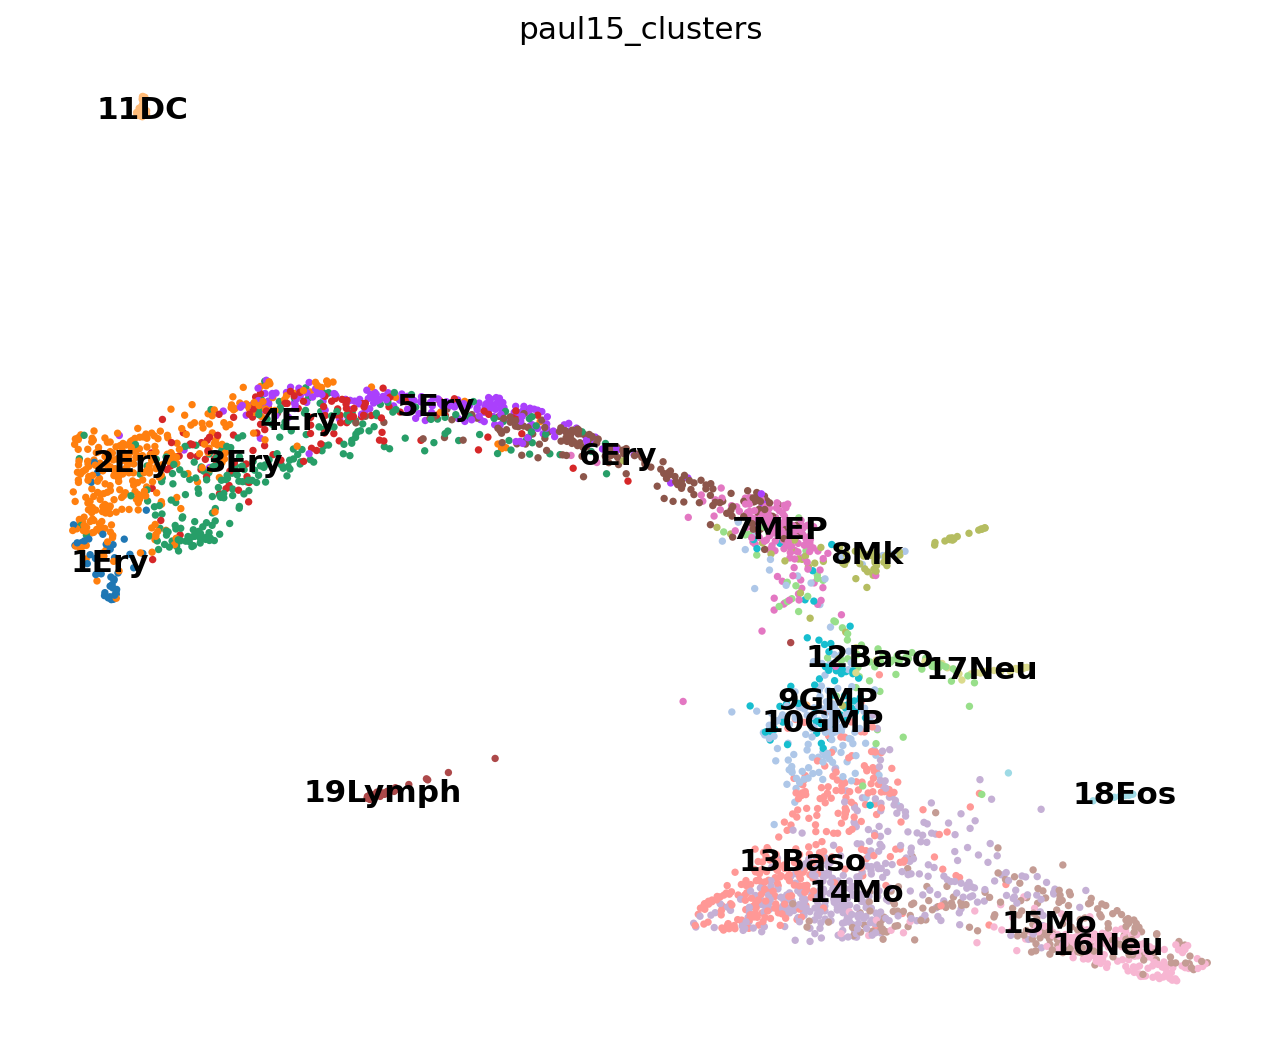

In [10]:
with plt.rc_context({'figure.figsize': (10, 8)}):
    sc.pl.draw_graph(adata, color="paul15_clusters", legend_loc="on data")

This looks pretty messy.

## Optional: Denoising the graph

To denoise the graph, we represent it in diffusion map space (and not in PCA space).
Computing distances within a few diffusion components amounts to denoising the graph – we just take a few of the first spectral components.
It's very similar to denoising a data matrix using PCA.
The approach has been used in a couple of papers, see e.g. {cite:p}`Schiebinger2019` or {cite:p}`Tabaka2019`. It's also related to the principles behind MAGIC {cite:p}`vanDijk2018`.

:::{note}
This is *not* a necessary step, neither for PAGA, nor clustering, nor pseudotime estimation. You might just as well go ahead with a non-denoised graph. In many situations (also here), this will give you very decent results.
:::

In [11]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_diffmap")

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989505  0.99597496 0.9939978  0.98925745
     0.9879414  0.98648685 0.9831232  0.98234713 0.9782109  0.9757828
     0.9739371  0.9737043  0.9637865 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [12]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:18)


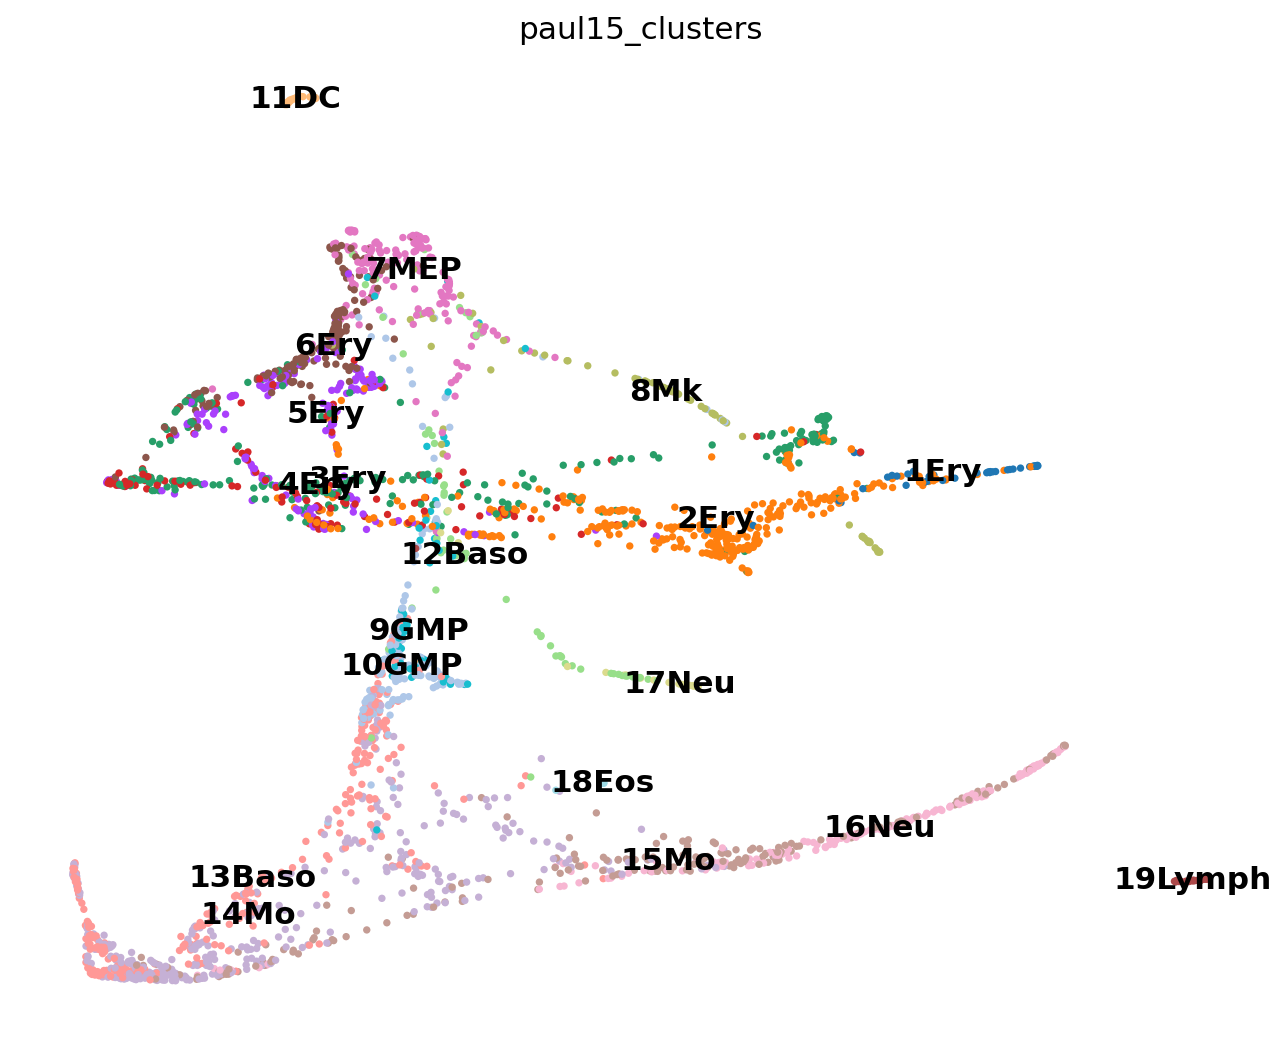

In [13]:
with plt.rc_context({'figure.figsize': (10, 8)}):
    sc.pl.draw_graph(adata, color="paul15_clusters", legend_loc="on data")

This still looks messy, but in a different way: a lot of the branches are overplotted.

## Clustering and PAGA

:::{note}
Note that today, we'd use `sc.tl.leiden` - here, we use `sc.tl.louvain` the sake of reproducing the paper results.
:::

In [14]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [15]:
sc.tl.paga(adata, groups="louvain")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


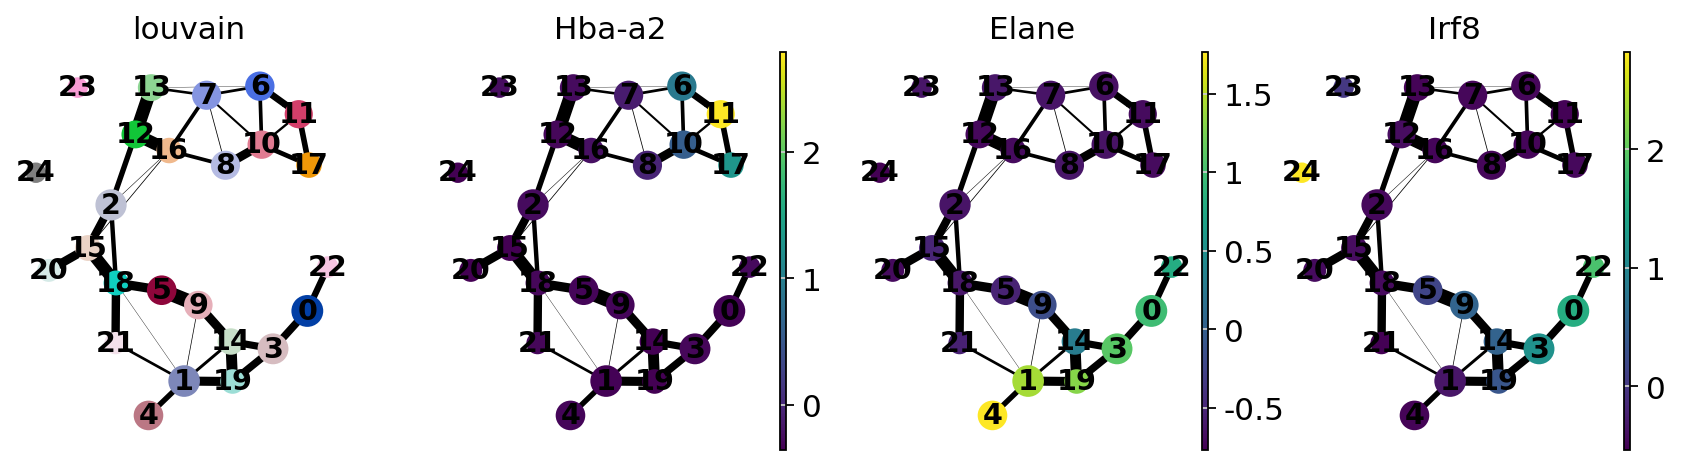

In [16]:
sc.pl.paga(adata, color=["louvain", "Hba-a2", "Elane", "Irf8"])

--> added 'pos', the PAGA positions (adata.uns['paga'])


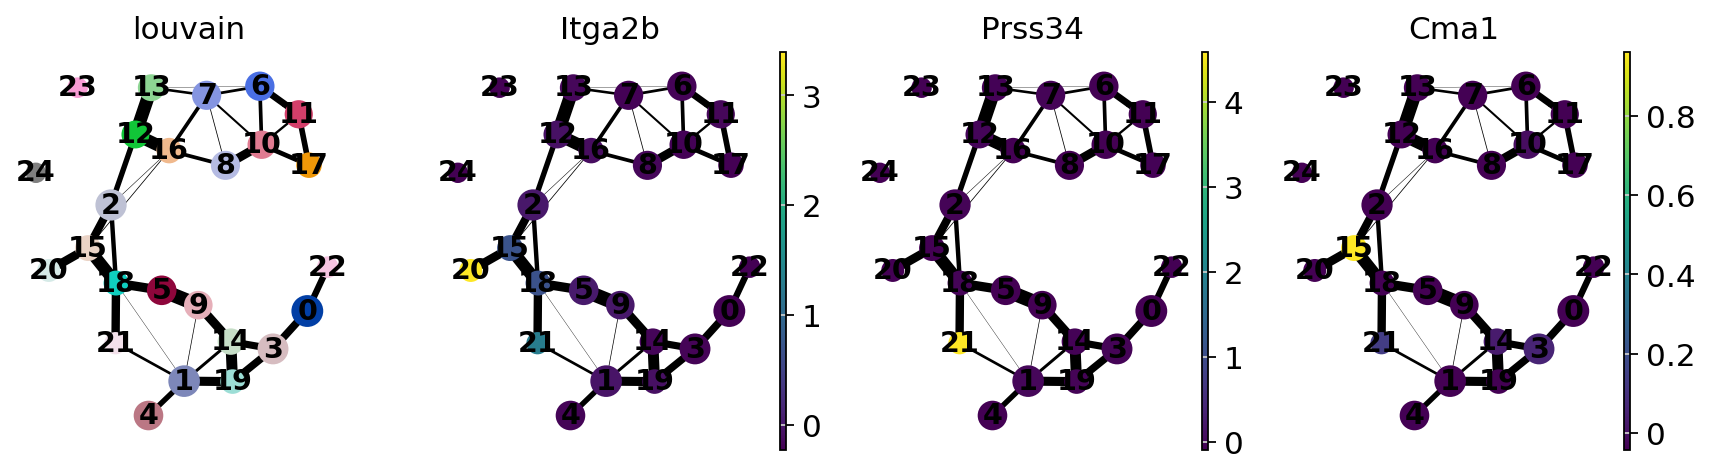

In [17]:
sc.pl.paga(adata, color=["louvain", "Itga2b", "Prss34", "Cma1"])

Actually annotate the clusters --- note that *Cma1* is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.

In [18]:
adata.obs["louvain"].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [19]:
adata.obs["louvain_anno"] = adata.obs["louvain"].cat.rename_categories(
    {
        "10": "10/Ery",
        "16": "16/Stem",
        "19": "19/Neu",
        "20": "20/Mk",
        "22": "22/Baso",
        "24": "24/Mo",
    }
)

Let's use the annotated clusters for PAGA.

In [20]:
sc.tl.paga(adata, groups="louvain_anno")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes: >

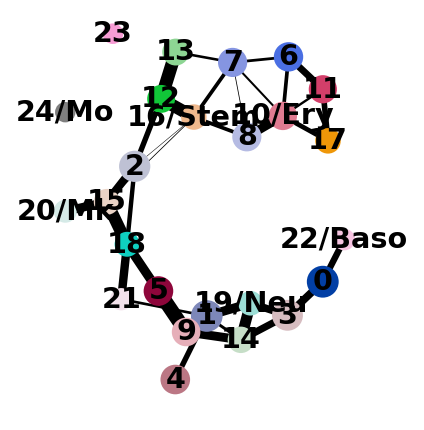

In [21]:
sc.pl.paga(adata, threshold=0.03, show=False)

## Recomputing the embedding using PAGA-initialization

The following is just as well possible for a UMAP.

In [22]:
sc.tl.draw_graph(adata, init_pos="paga")

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:17)


Now we can see all marker genes also at single-cell resolution in a meaningful layout.

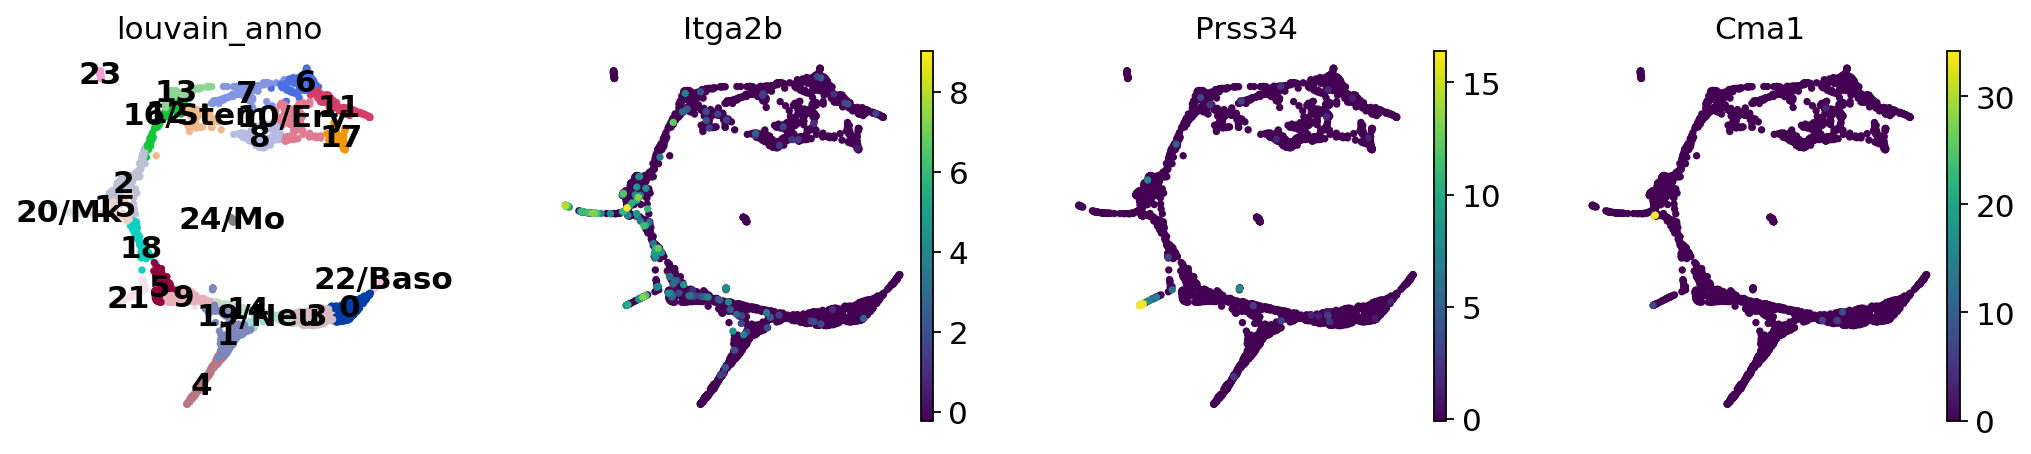

In [23]:
sc.pl.draw_graph(adata, color=["louvain_anno", "Itga2b", "Prss34", "Cma1"], legend_loc="on data")

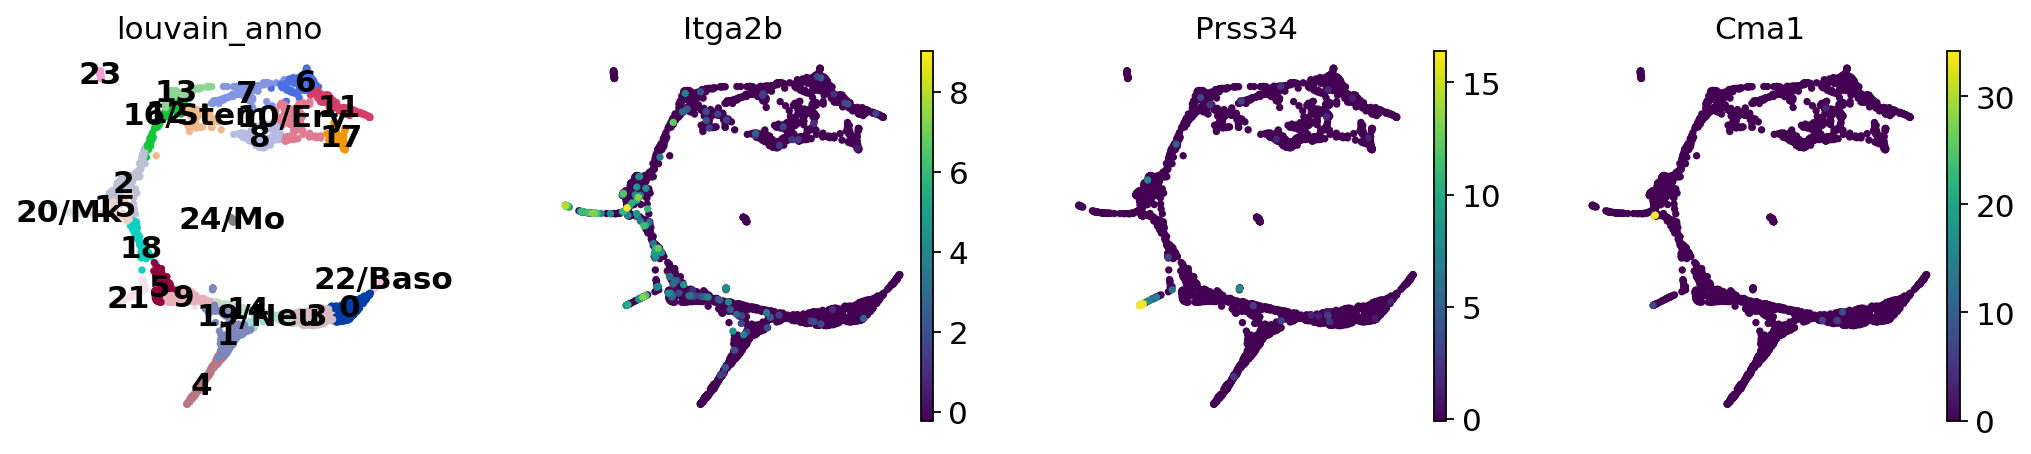

In [24]:
sc.pl.draw_graph(adata, color=["louvain_anno", "Itga2b", "Prss34", "Cma1"], legend_loc="on data")

Choose the colors of the clusters a bit more consistently.

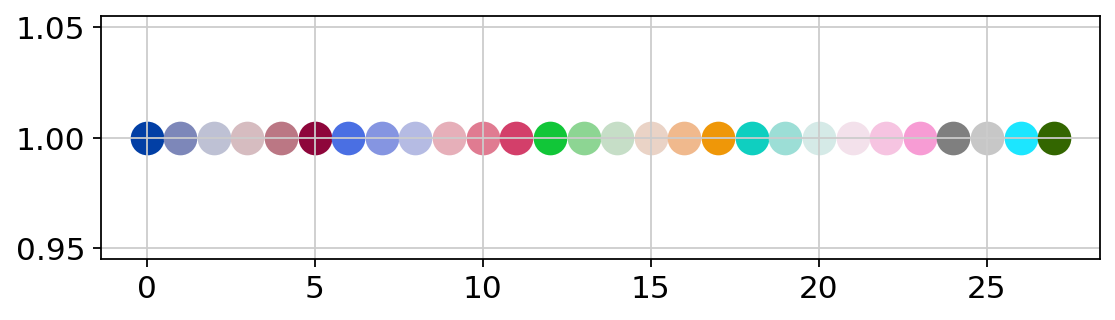

In [25]:
plt.figure(figsize=(8, 2))
for i in range(28):
    plt.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
plt.show()

In [26]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns["louvain_anno_colors"])

In [27]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[  # Ery colors / red
    [5, 5, 5, 5, 11, 11, 10, 9, 21, 21]
]
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [28]:
adata.uns["louvain_anno_colors"] = new_colors

And add some white space to some cluster names. The layout shown here differs from the one in the paper, which can be found [here](https://github.com/theislab/paga/blob/f53fcdf4a861b7d3410f8096ffc13a07f1d225c0/blood/paul15/paul15.ipynb). These differences, however, are only cosmetic. We had to change the layout as we moved from a randomized PCA and float32 to float64 precision.

--> added 'pos', the PAGA positions (adata.uns['paga'])


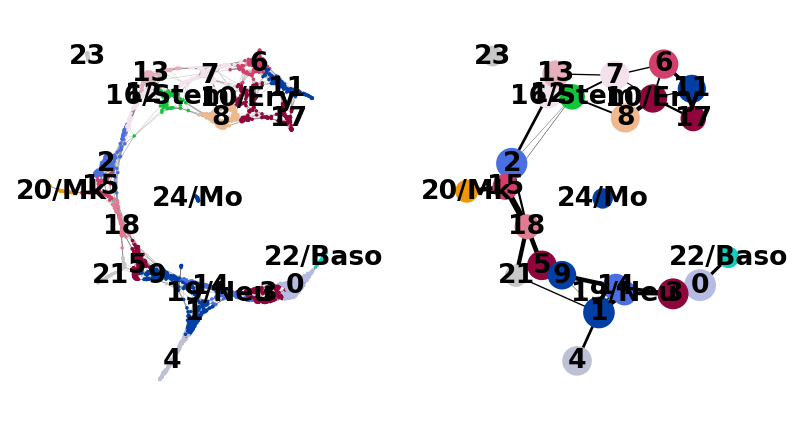

[<Axes: xlabel='FA1', ylabel='FA2'>, <Axes: >]

In [29]:
sc.pl.paga_compare(
    adata,
    threshold=0.03,
    title="",
    right_margin=0.2,
    size=10,
    edge_width_scale=0.5,
    legend_fontsize=12,
    fontsize=12,
    frameon=False,
    edges=True,
)

## Reconstructing gene changes along PAGA paths for a given set of genes

Choose a root cell for diffusion pseudotime.

In [30]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["louvain_anno"] == "16/Stem")[0]

In [31]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Select some of the marker gene names.

In [32]:
gene_names = [
    *["Gata2", "Gata1", "Klf1", "Epor", "Hba-a2"],  # erythroid
    *["Elane", "Cebpe", "Gfi1"],  # neutrophil
    *["Irf8", "Csf1r", "Ctsg"],  # monocyte
]

Use the full raw data for visualization.

In [33]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

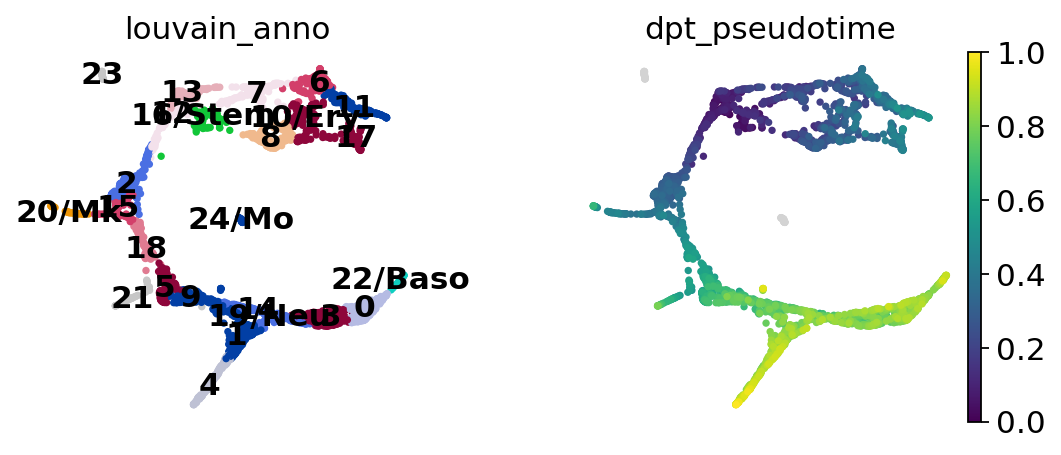

In [34]:
sc.pl.draw_graph(adata, color=["louvain_anno", "dpt_pseudotime"], legend_loc="on data")

In [39]:
paths = [
    ("erythrocytes", [16, 12, 7, 13, 18, 6, 5, 10]),
    ("neutrophils", [16, 0, 4, 2, 14, 19]),
    ("monocytes", [16, 0, 4, 11, 1, 9, 24]),
]

In [40]:
adata.obs["distance"] = adata.obs["dpt_pseudotime"]

In [41]:
adata.obs["clusters"] = adata.obs["louvain_anno"]  # just a cosmetic change

In [42]:
adata.uns["clusters_colors"] = adata.uns["louvain_anno_colors"]

In [43]:
!mkdir write

mkdir: cannot create directory ‘write’: File exists


/config/workspace/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1291: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/config/workspace/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1331: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


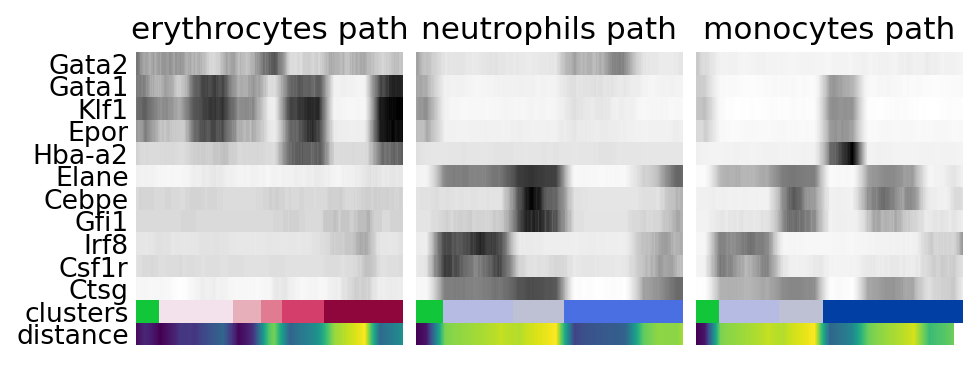

In [45]:
_, axs = plt.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={"wspace": 0.05, "left": 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    data = sc.pl.paga_path(
        adata,
        path,
        gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["distance"],
        show_yticks=ipath == 0,
        show_colorbar=False,
        color_map="Greys",
        groups_key="clusters",
        color_maps_annotations={"distance": "viridis"},
        title=f"{descr} path",
        return_data=True,
        show=False,
    )
    data.to_csv(f"./write/paga_path_{descr}.csv")
#plt.savefig("./figures/paga_path_paul15.pdf")
plt.show()